## Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
# import scipy as sc
# import sympy as sym
import numpy as np
from scipy.integrate import odeint

rng = np.random.default_rng(1273486192673491827301)


In [2]:
# sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.3)
mpl.rcParams['text.usetex'] = True

In [3]:
save_folder = "imgs/"

In [4]:
contested_cmap = mpl.colors.ListedColormap([
    "#FF9626", # 0 yellowish orange
    "#7EA74B", # 1 green
    "#006296", # 2 blue
    "#E26464", # 3 pink
    "#75557C", # 4 purple
    "#D9CB7E", # 5 beige
    "#4F6B30", # 6 dark green
    "#BC6C25", # 7 brown
])


variable_colors = {"marker": "grey",
                   "input": contested_cmap(1),
                   "interaction": contested_cmap(2),
                   "dynamics": contested_cmap(0),
                   "topology": contested_cmap(3)
                  }

top_colors = {'BA': contested_cmap(3),
              'ER': contested_cmap(2),
              'WS0.001':'greenyellow',
              'WS0.01': 'limegreen',
              'WS0.1': 'darkolivegreen',
              'RG': contested_cmap(0)
             }

attractor_colors = {'fixed_point' : contested_cmap(7),
                    'chaos' : contested_cmap(4),
                    'unbounded': contested_cmap(5),
                    'cycle': contested_cmap(6),
                   }


# inter_colors = {
#     (0, 0, 0, 0, 1): 'darkred',
#     (0, 0, 0, 0.5, 0.5): 'orangered',
#     (0, 0, 0, 1, 0): 'red',
#     (0, 0, 0.2, 0.8, 0): 'crimson',
#     (0, 0, 0.5, 0.5, 0): 'purple',
#     (0, 0, 0.8, 0.2, 0): 'blueviolet',
#     (0, 0, 1, 0, 0): 'blue'
# }

In [5]:
def tex_percent(values_list):
    return [f"{x[:-1]}\%" for x in ['{:,.0%}'.format(x) for x in values_list]]

In [6]:
def legend_outside_plot(fig, figlegend):
    ## ADJUST LEGEND OUTSIDE OF FIGURE ACCORDING TO SEABORN's CODE

    # Draw the plot to set the bounding boxes correctly
    fig.draw(fig.canvas.get_renderer())

    # Calculate and set the new width of the figure so the legend fits
    legend_width = figlegend.get_window_extent().width / fig.dpi
    fig_width, fig_height = fig.get_size_inches()
    fig.set_size_inches(fig_width + legend_width, fig_height)

    # Draw the plot again to get the new transformations
    fig.draw(fig.canvas.get_renderer())

    # Now calculate how much space we need on the right side
    legend_width = figlegend.get_window_extent().width / fig.dpi
    space_needed = legend_width / (fig_width + legend_width)
    margin = .01 # or .04
    _space_needed = margin + space_needed
    right = 1 - _space_needed 

    # Place the subplot axes to give space for the legend
    fig.subplots_adjust(right=right)

# Plot - 2 dimensions

## Define the ODEs

In [9]:
R_MF_carrCap = 200 # critical carrying capacity is 200
R_birth_rate = 2.
C_death_rate = 0.1
C_conversion_efficiency = 0.1
pred_max_dist = 0.06 # 3x the encounter radius
pred_rate = 0.001
comp_max_dist = 0.15 # 3x the encounter radius
init_centers_dist = 'random'
data_interval = 50
env_size = 1.
seed = 34567

tau = 0.1

prey_HR = .5
pred_HR = 20

In [31]:
# Define the system of ODEs for the prey-predator model
def dX_dt(X, t, r, alpha, epsilon, d, K):
    """Return the growth rate of fox and rabbit populations."""
    return np.array([ r*X[0]*(1. - X[0]/K) -   alpha*X[0]*X[1], 
                    -d*X[1] + epsilon*alpha*X[0]*X[1] ])

# Define a function to call the ODE solver
def solve_ode(X0, t, r, alpha, epsilon, d, K):
    """Solve the ODE system defined by dX_dt and return the solution."""
    return odeint(dX_dt, X0, t, args=(r, alpha, epsilon, d, K))

In [52]:

def calc_isoclines(r, alpha, epsilon, d, K, Rrange=2, Crange=2, points=200):
    # CALCULATE ISOCLINE VALUES
    # Change the function inside the np.array to match the isocline equations
    # Change the function parameters to match your ODEs
    iso_R = np.array([(R, r/alpha * (1. - R/K)) for R in np.linspace(0, Rrange,num=points)]).T
    iso_C = np.array([(d/(epsilon*alpha), C) for C in np.linspace(0, Crange,num=points)]).T
    
    # filter
    iso_R = np.array([x for x in iso_R if x[0] < Rrange])
    iso_C = np.array([x for x in iso_C if x[1] < Crange])
    
    return iso_R, iso_C


def pfs(r, alpha, epsilon, d, K):
    # CALCULATE FIXED POINTS
    # Adapt the function to match the fixed point equations
    # Change the function parameters to match your ODEs
    x0 = (0,0)
    x1 = (K,0)
    Rstar = d/(epsilon*alpha)
    x3 = (Rstar, r/alpha * (1. - Rstar/K))
    return [x0,x1,x3]

## Isoclines Figure

In [55]:
# SETUP

inchtocm = 2.54

title_kwargs = {}#'fontsize': 14}

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize = (7.25, np.sqrt(2)*7.25))


def plot_ODE_streamplot(r, alpha, epsilon, d, K, stab, ax=None, xrange=2, yrange=2, mesh_points=500j):
    # "stab" is a list of the fixed points, in the same order as the output of pfs()
    # if stab[i] == True, the ith fixed point is stable
    # Change the function parameters to match your ODEs
    # Change the x and y ranges

    Y, X = np.mgrid[0:xrange:mesh_points,0:yrange:mesh_points]
    
    if ax is None:
        ax = plt.gca()

    # CALCULATE THE DERIVATIVES
    # Change the function inside the np.array to match the ODEs
    # Change the function parameters to match your ODEs
    U = r*X*(1. - X/K) -   alpha*X*Y
    V = -d*Y + epsilon*alpha*X*Y
        # U, V = dX_dt(X, Y, r, alpha, epsilon, d, K)

    # ax.streamplot(X, Y, U, V, color='k', density=1., linewidth=1, arrowsize=1, arrowstyle='->')
    ax.streamplot(X, Y, U, V, density= .6, color='.4', linewidth=1.4)
    
    for isoc in calc_isoclines(r, alpha, epsilon, d, K, Rrange=xrange, Crange=yrange):
        ax.plot(*isoc, 'k', lw=2)
        
    for idx, pf in enumerate(pfs(r, alpha, epsilon, d, K)):
        if stab[idx]:
            ax.scatter(*pf, 130, color='k', zorder=2)
        else:
            ax.scatter(*pf, 100, facecolor='w', edgecolor='k', linewidths=2, zorder=4)
    
    # ax.set_xlim(-0.1, 1.1*xrange)
    # ax.set_ylim(-0.1, 1.1*yrange)
    return ax

(0.0, 250.0)

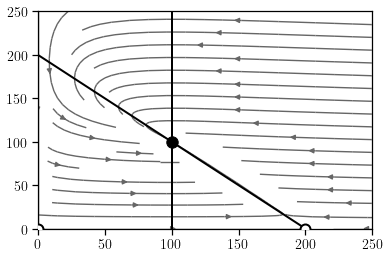

In [56]:
# Define parameter values, and the stability of the fixed points
r = R_birth_rate
alpha = pred_rate
epsilon = C_conversion_efficiency
d = C_death_rate
K = R_MF_carrCap
stab = [False, False, True]

# Initialize the figure

fig, ax = plt.subplots()

# Plot the Streamplot

xlim = 250
ylim = 250

plot_ODE_streamplot(r, alpha, epsilon, d, K, stab=stab, ax=ax, xrange=xlim, yrange=ylim, mesh_points=500j)
ax.set_xlim(0, xlim)
ax.set_ylim(0, ylim)
# ax.set_title('YOUR TITLE', **title_kwargs)

# Save the figure

# fig.show()
# fig.savefig('YOUR FILENAME.pdf', bbox_inches='tight')

## Vish

In [ ]:
import numpy as np
from scipy.integrate import odeint

In [ ]:
# call the ODE solver
t = np.arange(0, 200,  .1) # time
X0 = np.array([200, 10]) # initials conditions: 10 rabbits and 5 foxes
carrCap = 200
r = 2.
d = 0.1
epsilon = 0.1
alpha = 0.01
res = solve_ode(X0, t, r, alpha, epsilon, d, carrCap)

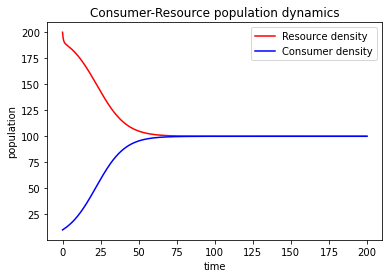

In [ ]:
# plot the results using the object-oriented interface
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(t, res[:, 0], 'r-', label='Resource density')
ax.plot(t, res[:, 1]  , 'b-', label='Consumer density')
# ax.grid()
ax.legend(loc='best')
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_title('Consumer-Resource population dynamics')
plt.show()

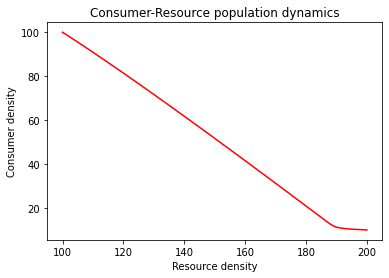

In [ ]:
# construct a diagram of the phase space of the consumer-resource population dynamics
fig, ax = plt.subplots()
ax.plot(res[:, 0], res[:, 1], 'r-', label='Consumer-Resource population dynamics')
ax.set_xlabel('Resource density')
ax.set_ylabel('Consumer density')
ax.set_title('Consumer-Resource population dynamics')
plt.show()

In [ ]:
res[-1, 1]

99.99999905437362

In [ ]:
def arrowed_spines(
        ax,
        x_width_fraction=0.05,
        x_height_fraction=0.05,
        lw=None,
        ohg=0.3,
        locations=('bottom right', 'left up'),
        **arrow_kwargs
):
    """
    Add arrows to the requested spines
    Code originally sourced here: https://3diagramsperpage.wordpress.com/2014/05/25/arrowheads-for-axis-in-matplotlib/
    And interpreted here by @Julien Spronck: https://stackoverflow.com/a/33738359/1474448
    Then corrected and adapted by me for more general applications.
    :param ax: The axis being modified
    :param x_{height,width}_fraction: The fraction of the **x** axis range used for the arrow height and width
    :param lw: Linewidth. If not supplied, default behaviour is to use the value on the current left spine.
    :param ohg: Overhang fraction for the arrow.
    :param locations: Iterable of strings, each of which has the format "<spine> <direction>". These must be orthogonal
    (e.g. "left left" will result in an error). Can specify as many valid strings as required.
    :param arrow_kwargs: Passed to ax.arrow()
    :return: Dictionary of FancyArrow objects, keyed by the location strings.
    """
    # set/override some default plotting parameters if required
    arrow_kwargs.setdefault('overhang', ohg)
    arrow_kwargs.setdefault('clip_on', False)
    arrow_kwargs.update({'length_includes_head': True})

    # axis line width
    if lw is None:
        # FIXME: does this still work if the left spine has been deleted?
        lw = ax.spines['left'].get_linewidth()

    annots = {}

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # get width and height of axes object to compute
    # matching arrowhead length and width
    fig = ax.get_figure()
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = x_width_fraction * (ymax-ymin)
    hl = x_height_fraction * (xmax-xmin)

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    for loc_str in locations:
        side, direction = loc_str.split(' ')
        assert side in {'top', 'bottom', 'left', 'right'}, "Unsupported side"
        assert direction in {'up', 'down', 'left', 'right'}, "Unsupported direction"

        if side in {'bottom', 'top'}:
            if direction in {'up', 'down'}:
                raise ValueError("Only left/right arrows supported on the bottom and top")

            dy = 0
            head_width = hw
            head_length = hl

            y = ymin if side == 'bottom' else ymax

            if direction == 'right':
                x = xmin
                dx = xmax - xmin
            else:
                x = xmax
                dx = xmin - xmax

        else:
            if direction in {'left', 'right'}:
                raise ValueError("Only up/downarrows supported on the left and right")
            dx = 0
            head_width = yhw
            head_length = yhl

            x = xmin if side == 'left' else xmax

            if direction == 'up':
                y = ymin
                dy = ymax - ymin
            else:
                y = ymax
                dy = ymin - ymax


        annots[loc_str] = ax.arrow(x, y, dx, dy, fc='k', ec='k', lw = lw,
                 head_width=head_width, head_length=head_length, **arrow_kwargs)

    return annots

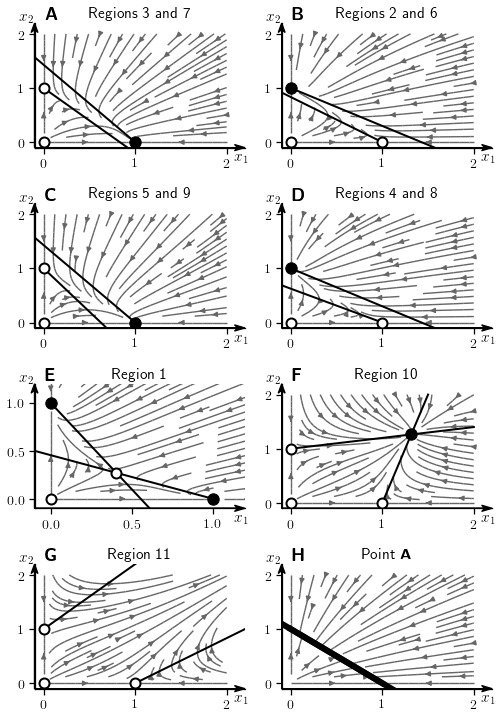